In [46]:
import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [47]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "04_deep_learning_model" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 8


In [48]:
import urllib, requests #for Telegram notifications

def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [49]:
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [50]:
features_num = train_df.drop(['id','target'], axis=1).columns
X = train_df.drop(['id','target'], axis=1).copy()
y = train_df['target'].copy()
X_test = test_df.drop(['id'], axis=1).copy()


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(StandardScaler(),)

preprocessor = make_column_transformer((transformer_num, features_num),)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, train_size=0.75, random_state=rnd_state
)

# X_train = preprocessor.fit_transform(X_train)
# X_valid = preprocessor.transform(X_valid)
# X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print(input_shape)


[100]


In [52]:
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
gc.collect()

# Set seed
tf.random.set_seed(rnd_state)

model = keras.Sequential(
    [
        layers.Dense(4, activation="relu", input_shape=input_shape),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid"),  # sigmoid for binary output
    ]
)

model.summary()

model.compile(
    optimizer="adam",  # SGD is more sensitive to differences of scale
    loss="binary_crossentropy",
    metrics=["AUC"],
)

early_stopping = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  # hide the output because we have so many epochs
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 404       
                                                                 
 dense_13 (Dense)            (None, 4)                 20        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


Best Validation Loss: 0.569600
Best Validation AUC: 0.750102


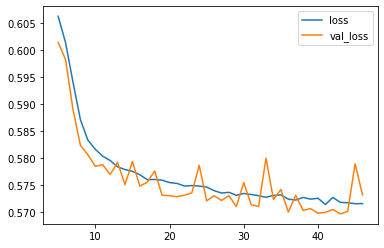

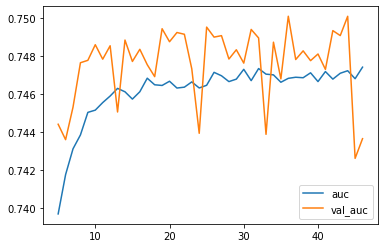

In [55]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["auc", "val_auc"]].plot()

print(
    ("Best Validation Loss: {:0.6f}" + "\nBest Validation AUC: {:0.6f}").format(
        history_df["val_loss"].min(), history_df["val_auc"].max()
    )
)

# ADAM:
# Best Validation Loss: 0.564178
# Best Validation Accuracy: 0.757301

# SGD:
# Best Validation Loss: 0.565582
# Best Validation Accuracy: 0.750882


In [56]:
best_score = 0
best_score = history_df["val_auc"].max()
print(best_score)

message = f'New best score: {best_score}'
send_telegram_message(message)

0.750102162361145


In [57]:
preds_test = model.predict(X_test)

# Submitting Results

In [58]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

#mlflow_run_id = str(run.info.run_id)
objective = "dl_test"

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = preds_test
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)

2021-11-11_submission_dl_test.csv


In [59]:
sample_df.tail()

,id,target
539995,1139995,0.746565
539996,1139996,0.745638
539997,1139997,0.555901
539998,1139998,0.745628
539999,1139999,0.745994


In [60]:
# !kaggle competitions submit tabular-playground-series-nov-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}

# Tuning Hyperparameters w/ Optuna

In [70]:
import warnings
from icecream import ic
import optuna

from keras.backend import clear_session
from keras.layers import Dense
from keras.models import Sequential

In [71]:
def objective(trial):
    global best_score
    # Clear clutter from previous Keras session graphs.
    clear_session()
    gc.collect()

    # Set seed
    tf.random.set_seed(rnd_state)

    train_df = pd.read_pickle(PATH_DATA_INT + "train-opt.pkl")
    X = train_df.drop(["id", "target"], axis=1)
    y = train_df["target"]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, stratify=y, train_size=0.75, random_state=rnd_state,
    )

    input_shape = [X_train.shape[1]]

    model = Sequential()

    batch_size = trial.suggest_int("batch_size", 10, 600)
    # epochs = trial.suggest_int("epochs", 100, 1000, 100)
    epochs = 2000  # we are using early stops to control the epochs
    n_layers = trial.suggest_int("n_layers", 1, 3, 1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    patience = trial.suggest_int("patience", 10, 100)
    # optimizer=trial.suggest_categorical("activation", ["sgd", "adam"]) # TODO: needs to be updated, not working yet

    # model.add(keras.layers.Flatten())
    # model.add(layers.Dense(input_shape=input_shape, activation="relu"))

    model.add(layers.BatchNormalization(input_shape=input_shape))

    for i in range(n_layers):
        num_hidden = trial.suggest_int(f"n_units_l{i}", 4, input_shape[0], log=True)
        model.add(layers.Dense(num_hidden, activation="relu"))
        # ic(num_hidden)

    # last layer
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"],
    )

    early_stopping = EarlyStopping(
        patience=patience, min_delta=learning_rate, restore_best_weights=True,
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),  # TODO: Test Keras validation function
        # shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0,  # hide the output because we have so many epochs
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_valid, y_valid, verbose=0)

    if score[1] > best_score:
        best_score = score[1]
        ic(best_score)
        message = f'New best score: {best_score}'
        send_telegram_message(message)

    return score[1]


In [72]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) # TODO: load, split and send data from function


[I 2021-11-11 14:06:37,145] A new study created in memory with name: no-name-78afa79a-eb6b-44d2-ba7c-abebff9db439
[I 2021-11-11 14:13:14,308] Trial 0 finished with value: 0.7505078911781311 and parameters: {'batch_size': 306, 'n_layers': 3, 'learning_rate': 0.004823093340195842, 'patience': 44, 'n_units_l0': 20, 'n_units_l1': 86, 'n_units_l2': 58}. Best is trial 0 with value: 0.7505078911781311.
[I 2021-11-11 14:15:56,771] Trial 1 finished with value: 0.7394093871116638 and parameters: {'batch_size': 167, 'n_layers': 1, 'learning_rate': 0.05091416795116642, 'patience': 10, 'n_units_l0': 28}. Best is trial 0 with value: 0.7505078911781311.
[I 2021-11-11 14:23:00,598] Trial 2 finished with value: 0.7543767690658569 and parameters: {'batch_size': 512, 'n_layers': 3, 'learning_rate': 0.004184038313741596, 'patience': 43, 'n_units_l0': 7, 'n_units_l1': 4, 'n_units_l2': 18}. Best is trial 2 with value: 0.7543767690658569.
[I 2021-11-11 14:27:20,932] Trial 3 finished with value: 0.75329422950

KeyboardInterrupt: 

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
